In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from datetime import date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearnex import patch_sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings

## Traffic data
The traffic data that is imported here is taken from the **TrafficDataCleaning file**, where detailed steps about the cleaning of the dataset have been specified as well as a data dictionary with data requirements. 
### Importing the data

In [2]:
traffic_data = pd.read_csv("datasets/CleanTraffic.csv")
traffic_data.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseCodeDescr,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime
587835,3950052,2024-02-16,2024-02-16,16:49:31,16:54:00,15.617,3483.000,4.483,59.1,55.7,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 4],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-02-16 16:49:31,2024-02-16 16:54:00
1004971,2349260,2018-05-24,2018-05-24,16:49:00,16:57:54,31.433,3531.835,8.900,142.2,146.2,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 9],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2018-05-24 16:49:00,2018-05-24 16:57:54
1623635,2193115,2017-07-28,2017-07-28,12:02:00,12:16:45,51.783,3510.735,14.750,29.2,24.2,...,Ophoogscript,[Ophoogscript 15],[YDP],YDP,Ophoogscript,Werkzaamheden gevonden door WiFi-script,Werkzaamheden,Aanleg en gepland onderhoud,2017-07-28 12:02:00,2017-07-28 12:16:45


In [3]:
traffic_data.shape

(1714882, 28)

### Checking the data types and missing values

In [4]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714882 entries, 0 to 1714881
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   TrafficJamNum        int64  
 1   StartDate            object 
 2   EndDate              object 
 3   StartTime            object 
 4   EndTime              object 
 5   Severity             float64
 6   Length               float64
 7   Duration             float64
 8   HectometerStart      float64
 9   HectometerEnd        float64
 10  RoadLetter           object 
 11  RoadNumber           int64  
 12  RoadDescr            object 
 13  HectometerDirection  object 
 14  RoadSectionFrom      object 
 15  RoadSectionTo        object 
 16  MainRoadFrom         object 
 17  MainRoadTo           object 
 18  CauseCodeDescr       object 
 19  CauseClass           object 
 20  CauseCodeClass       object 
 21  CauseCode            object 
 22  Cause_1              object 
 23  Cause_2              object 
 24

In [5]:
traffic_data.isna().sum()

TrafficJamNum          0
StartDate              0
EndDate                0
StartTime              0
EndTime                0
Severity               0
Length                 0
Duration               0
HectometerStart        0
HectometerEnd          0
RoadLetter             0
RoadNumber             0
RoadDescr              0
HectometerDirection    0
RoadSectionFrom        0
RoadSectionTo          0
MainRoadFrom           0
MainRoadTo             0
CauseCodeDescr         0
CauseClass             0
CauseCodeClass         0
CauseCode              0
Cause_1                0
Cause_2                0
Cause_3                0
Cause_4                0
StartDateTime          0
EndDateTime            0
dtype: int64

### Altering data
#### Adding hour

In [6]:
traffic_data['Hour'] = traffic_data['StartTime'].apply(lambda x: x.split(':')[0]).astype(int)
traffic_data.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour
1361565,2133429,2017-04-07,2017-04-07,15:27:00,15:31:11,8.367,2000.0,4.183,163.7,165.7,...,[Geen oorzaakcode opgegeven door VWM 4],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2017-04-07 15:27:00,2017-04-07 15:31:11,15
485297,3203663,2022-10-03,2022-10-03,7:48:26,7:52:00,9.523,2670.0,3.567,19.0,16.7,...,[Geen oorzaakcode opgegeven door VWM 4],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-10-03 07:48:26,2022-10-03 07:52:00,7
546556,3049609,2022-05-28,2022-05-28,13:30:27,13:32:00,4.030,2600.0,1.550,19.0,16.4,...,[Geen oorzaakcode opgegeven door VWM 2],[000],003,File buiten spits (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-05-28 13:30:27,2022-05-28 13:32:00,13


#### Keeping only relevant roads

As we want to only have the specific roads that our client can possibly use to reach the offices, we will prepare the data for joining by filtering on the roads A2 and A73.
An important observation is that **A2 leads from Sittard to 's-Hertogenbosch** and vice versa, whereas **A73 leads from Sittard to Boxmeer** and vice versa. Other routes are also possible, but they are significantly slower. Therefore, it is better to focus on those two only for now. Furthermore, they have been suggested by the client as the optimal routes.

In [7]:
filtered_traffic= traffic_data[(traffic_data['RoadDescr'] == 'A73') | (traffic_data['RoadDescr'] == 'A2')]
filtered_traffic.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour
646786,3875116,2023-12-12,2023-12-12,8:06:29,8:11:03,10.465,2292.0,4.567,75.3,77.4,...,[Geen oorzaakcode opgegeven door VWM 5],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2023-12-12 08:06:29,2023-12-12 08:11:03,8
526308,3037433,2022-05-20,2022-05-20,14:21:28,14:29:00,29.748,3949.0,7.533,179.4,184.0,...,[Geen oorzaakcode opgegeven door VWM 8],[000],003,File buiten spits (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-05-20 14:21:28,2022-05-20 14:29:00,14
334833,3286133,2022-11-22,2022-11-22,8:25:27,8:29:01,7.817,2192.0,3.567,178.4,180.5,...,[Geen oorzaakcode opgegeven door VWM 4],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-11-22 08:25:27,2022-11-22 08:29:01,8


In [8]:
denb=filtered_traffic[(filtered_traffic["MainRoadFrom"] == "'s-Hertogenbosch")&(filtered_traffic["MainRoadTo"] == "Utrecht")]
denb["HectometerDirection"].unique()

array(['aflopend'], dtype=object)

### Making the direction numerical
0 = Morning (Sittard - Den Bosch)

1 = Afternoon (Den Bosch - Sittard)

In [9]:
warnings.filterwarnings('ignore')
filtered_traffic.loc[filtered_traffic["HectometerDirection"]=="oplopend", 'HectometerDirectionNum'] = 1
filtered_traffic.loc[filtered_traffic["HectometerDirection"]=="aflopend", 'HectometerDirectionNum'] = 0

filtered_traffic.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour,HectometerDirectionNum
743151,3908303,2024-01-17,2024-01-17,15:31:29,16:05:02,78.727,2347.000,33.550,43.9,46.1,...,[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-17 15:31:29,2024-01-17 16:05:02,15,0.0
1439853,2470599,2018-12-18,2018-12-18,7:36:00,7:42:50,13.667,2000.000,6.833,132.6,130.6,...,[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2018-12-18 07:36:00,2018-12-18 07:42:50,7,1.0
869917,2058920,2016-11-21,2016-11-21,8:16:00,8:21:18,13.083,2468.554,5.300,102.3,105.3,...,[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2016-11-21 08:16:00,2016-11-21 08:21:18,8,0.0


### Removing useless columns

In [10]:
numerical_columns = filtered_traffic.select_dtypes(include=['int64', 'float64', 'int32'])
desired_columns = ["StartDate", "Duration", "RoadNumber", "Hour", "HectometerDirectionNum"]
selected_columns = filtered_traffic.loc[:, desired_columns]
selected_columns['StartDate'] = pd.to_datetime(selected_columns['StartDate'])
selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209047 entries, 9 to 1714873
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   StartDate               209047 non-null  datetime64[ns]
 1   Duration                209047 non-null  float64       
 2   RoadNumber              209047 non-null  int64         
 3   Hour                    209047 non-null  int32         
 4   HectometerDirectionNum  209047 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 8.8 MB


It can be concluded that the file got imported correctly and is ready to be used further.
## Calendar

In [11]:
def create_date_table2(start, end):
    date_range = pd.date_range(start=start, end=end, freq='h')
    df = pd.DataFrame({"DateTime": date_range})
    df["StartDate"] = df["DateTime"].dt.date
    df["Hour"] = df["DateTime"].dt.hour
    return df

calendar = create_date_table2(start='2015-01-01', end=selected_columns['StartDate'].max())
calendar = calendar.drop(calendar.columns[0], axis=1)
calendar['StartDate'] = pd.to_datetime(calendar['StartDate'])
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82705 entries, 0 to 82704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   StartDate  82705 non-null  datetime64[ns]
 1   Hour       82705 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 969.3 KB


### Join road A2 and direction 1

In [12]:
a2d1 = selected_columns[(selected_columns['RoadNumber']==2)&(selected_columns['HectometerDirectionNum']==1)]
a2d1.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
1704888,2022-01-27,44.2,2,16,1.0
1596531,2018-02-07,5.2,2,17,1.0


In [13]:
mergedoutera2d1 = pd.merge(calendar, a2d1, how='left', on=['StartDate', 'Hour'])
mergedoutera2d1.isna().sum()

StartDate                     0
Hour                          0
Duration                  68061
RoadNumber                68061
HectometerDirectionNum    68061
dtype: int64

In [14]:
mergedoutera2d1['Duration'] = mergedoutera2d1['Duration'].fillna(0)
mergedoutera2d1['RoadNumber'] = mergedoutera2d1['RoadNumber'].fillna(2)
mergedoutera2d1['HectometerDirectionNum'] = mergedoutera2d1['HectometerDirectionNum'].fillna(1)
mergedoutera2d1.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [15]:
mergedoutera2d1.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
32628,2017-01-31,3,0.000,2.0,1.0
12001,2015-11-02,8,13.333,2.0,1.0


### Join road A2 and direction 0

In [16]:
a2d0 = selected_columns[(selected_columns['RoadNumber']==2)&(selected_columns['HectometerDirectionNum']==0)]
a2d0.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
1489614,2018-01-15,11.633,2,7,0.0
678830,2022-04-25,18.533,2,8,0.0


In [17]:
mergedoutera2d0 = pd.merge(calendar, a2d0, how='left', on=['StartDate', 'Hour'])
mergedoutera2d0.isna().sum()

StartDate                     0
Hour                          0
Duration                  67311
RoadNumber                67311
HectometerDirectionNum    67311
dtype: int64

In [18]:
mergedoutera2d0['Duration'] = mergedoutera2d0['Duration'].fillna(0)
mergedoutera2d0['RoadNumber'] = mergedoutera2d0['RoadNumber'].fillna(2)
mergedoutera2d0['HectometerDirectionNum'] = mergedoutera2d0['HectometerDirectionNum'].fillna(0)
mergedoutera2d0.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [19]:
mergedoutera2d0.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
156517,2024-06-04,8,20.567,2.0,0.0
78569,2020-05-18,2,0.000,2.0,0.0


### Join A73 and direction 1

In [20]:
a73d1 = selected_columns[(selected_columns['RoadNumber']==73)&(selected_columns['HectometerDirectionNum']==1)]
a73d1.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
86793,2024-05-07,7.500,73,16,1.0
697773,2022-12-01,1.567,73,7,1.0


In [21]:
mergedoutera73d1 = pd.merge(calendar, a73d1, how='left', on=['StartDate', 'Hour'])
mergedoutera73d1.isna().sum()

StartDate                     0
Hour                          0
Duration                  78221
RoadNumber                78221
HectometerDirectionNum    78221
dtype: int64

In [22]:
mergedoutera73d1['Duration'] = mergedoutera73d1['Duration'].fillna(0)
mergedoutera73d1['RoadNumber'] = mergedoutera73d1['RoadNumber'].fillna(73)
mergedoutera73d1['HectometerDirectionNum'] = mergedoutera73d1['HectometerDirectionNum'].fillna(1)
mergedoutera73d1.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [23]:
mergedoutera73d1.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
84115,2023-09-18,7,4.533,73.0,1.0
54979,2021-02-06,4,0.000,73.0,1.0


### Join A73 and direction 0

In [24]:
a73d0 = selected_columns[(selected_columns['RoadNumber']==73)&(selected_columns['HectometerDirectionNum']==0)]
a73d0.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
1287104,2020-02-21,16.333,73,15,0.0
491095,2022-10-07,6.333,73,16,0.0


In [25]:
mergedoutera73d0 = pd.merge(calendar, a73d0, how='left', on=['StartDate', 'Hour'])
mergedoutera73d0.isna().sum()

StartDate                     0
Hour                          0
Duration                  79686
RoadNumber                79686
HectometerDirectionNum    79686
dtype: int64

In [26]:
mergedoutera73d0['Duration'] = mergedoutera73d0['Duration'].fillna(0)
mergedoutera73d0['RoadNumber'] = mergedoutera73d0['RoadNumber'].fillna(73)
mergedoutera73d0['HectometerDirectionNum'] = mergedoutera73d0['HectometerDirectionNum'].fillna(0)
mergedoutera73d0.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [27]:
mergedoutera73d0.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
59407,2021-09-18,13,0.0,73.0,0.0
84453,2023-12-29,8,0.0,73.0,0.0


### Appending the 4 dataframes

In [28]:
dataframes = [mergedoutera2d0, mergedoutera2d1, mergedoutera73d0, mergedoutera73d1]
appended_frame = pd.concat(dataframes, axis=0)
appended_frame.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [29]:
appended_frame.shape

(502317, 5)

In [30]:
appended_frame.sample(5)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
63563,2022-01-24,12,0.000,73.0,1.0
85239,2020-01-28,15,12.200,2.0,1.0
9472,2015-10-01,8,4.833,2.0,0.0
46739,2017-12-15,1,0.000,2.0,1.0
29176,2018-04-26,3,0.000,73.0,0.0


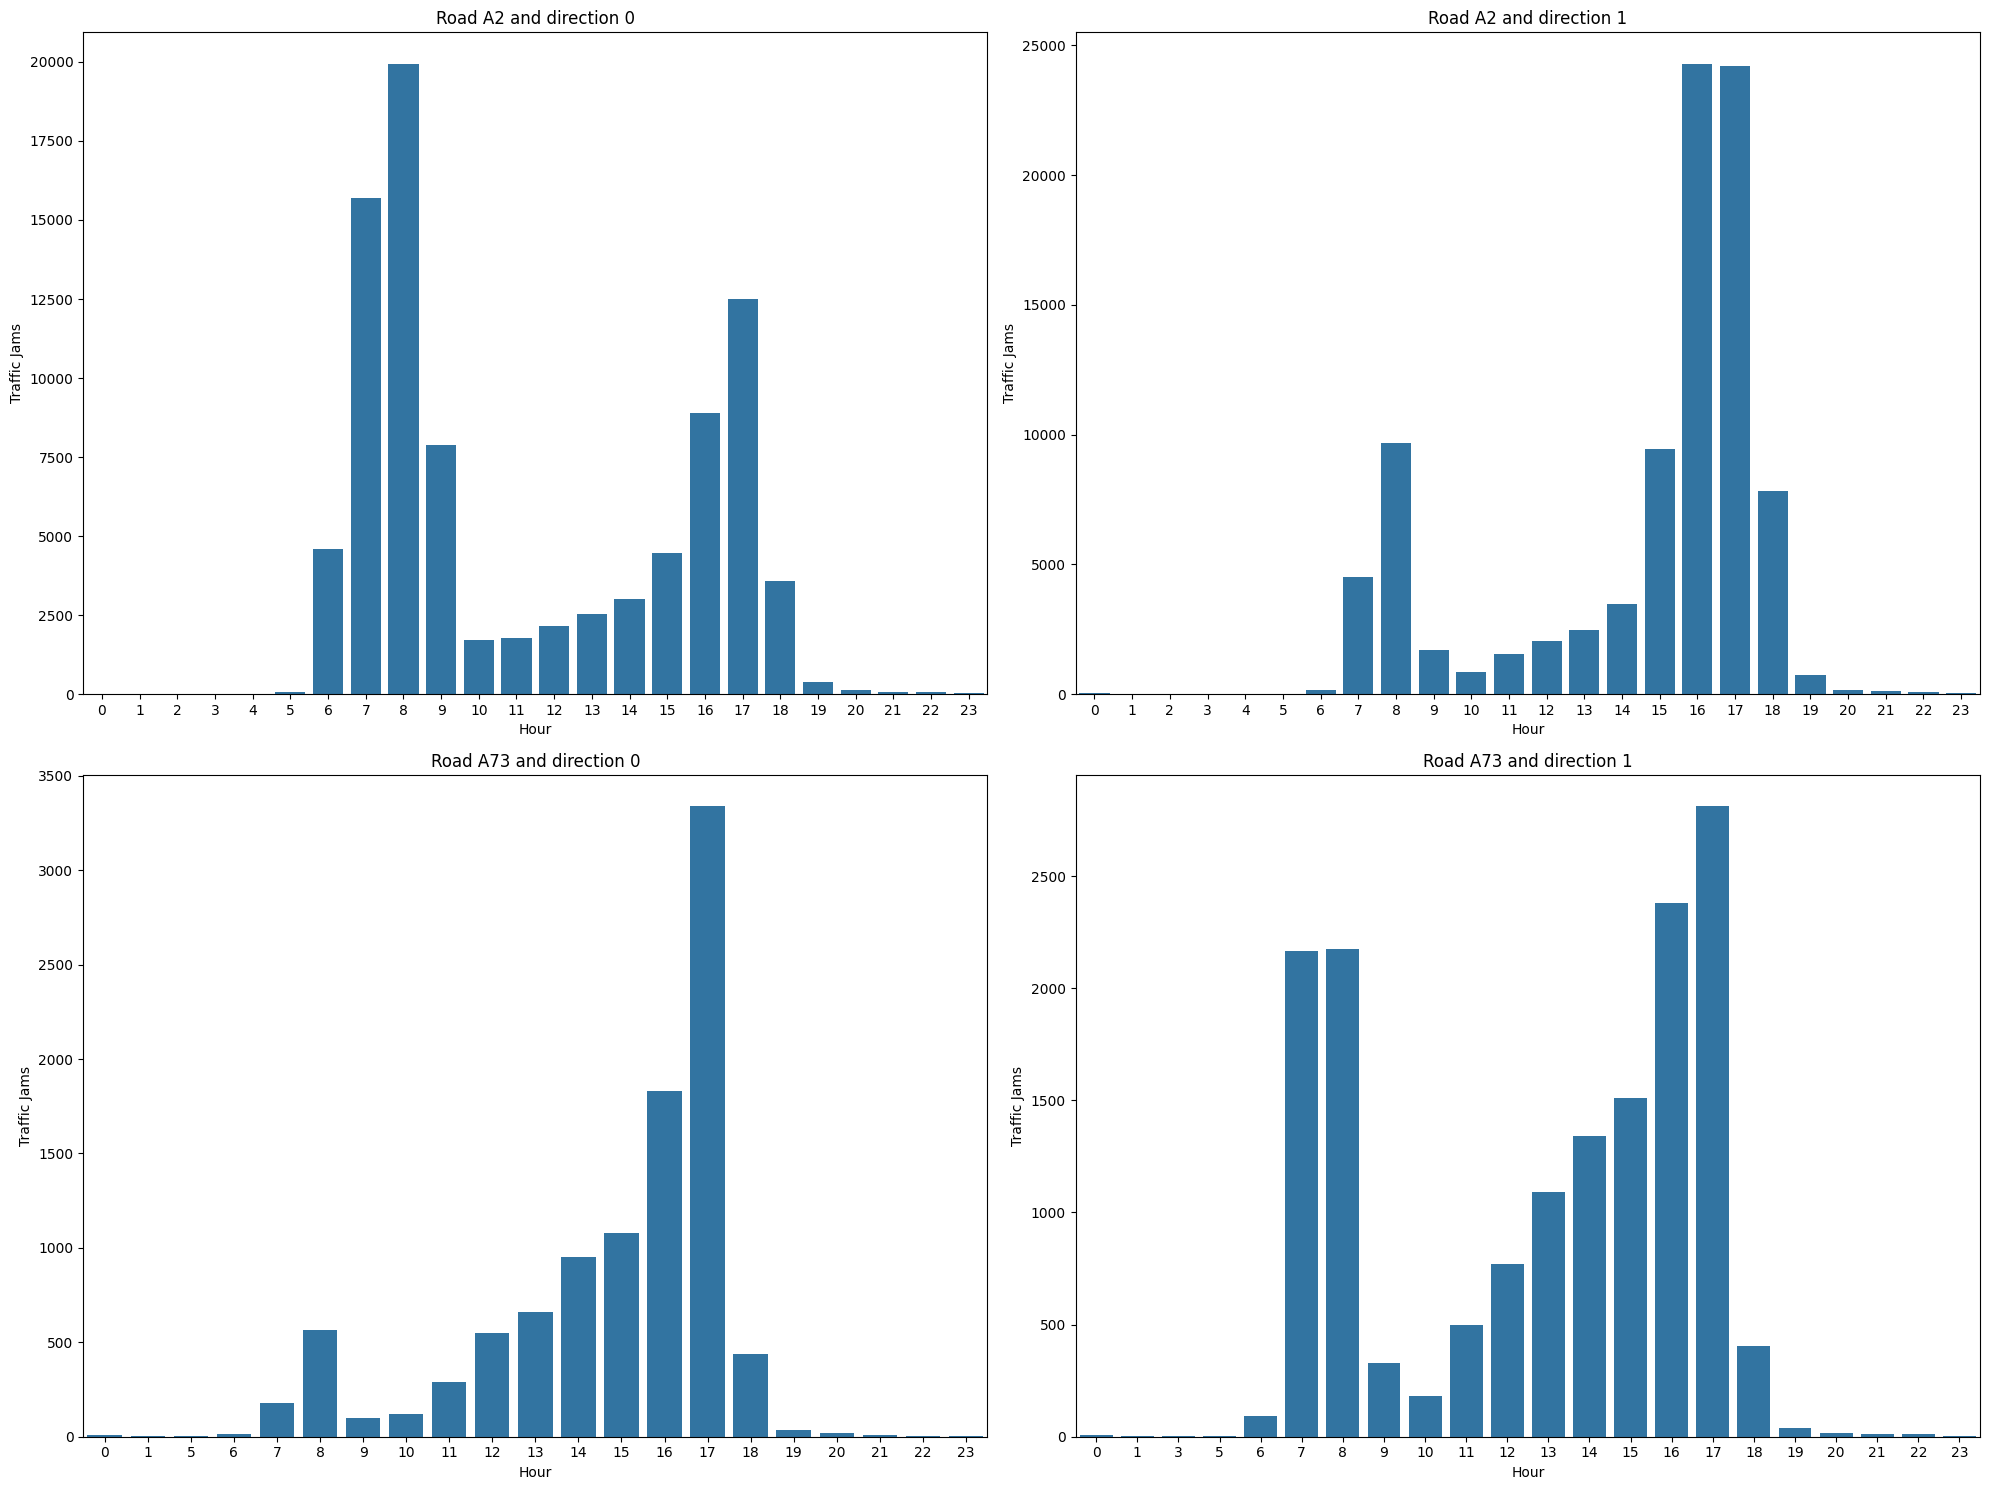

In [98]:
import seaborn as sns

actualtr0 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==0)&(appended_frame['RoadNumber']==2)]
actualtr0 = actualtr0['Hour'].value_counts().sort_index() 

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.barplot(x=actualtr0.index, y=actualtr0.values, ax = axes[0,0])
axes[0, 0].set_title('Road A2 and direction 0')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Traffic Jams')


actualtr1 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==1)&(appended_frame['RoadNumber']==2)]
actualtr1 = actualtr1['Hour'].value_counts().sort_index()

sns.barplot(x=actualtr1.index, y=actualtr1.values, ax = axes[0,1])
axes[0, 1].set_title('Road A2 and direction 1')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Traffic Jams')

actualtr2 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==0)&(appended_frame['RoadNumber']==73)]
actualtr2 = actualtr2['Hour'].value_counts().sort_index() 


sns.barplot(x=actualtr2.index, y=actualtr2.values, ax = axes[1,0])
axes[1, 0].set_title('Road A73 and direction 0')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Traffic Jams')


actualtr3 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==1)&(appended_frame['RoadNumber']==73)]
actualtr3 = actualtr3['Hour'].value_counts().sort_index()

sns.barplot(x=actualtr3.index, y=actualtr3.values, ax = axes[1,1])
axes[1, 1].set_title('Road A73 and direction 1')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Traffic Jams')

plt.tight_layout()
plt.show()

#### Cause 1 mapping into categories for filtered_traffic

In [122]:


# Define the classification mapping
classification_mapping = {
    'Accidents and Vehicle Issues': [
        'Ongeval(len)', 'Ongeval op aansluitende weg', 'Ongevalsonderzoek', 'Ongeval met vrachtwagen(s)', 
        'Ongeval met bus(sen)', 'Ongeval met weglekkende brandstof', 'Ongeval(len) met gevaarlijke stoffen', 
        'Ongeval (len) met olielekkage', 'Ongeval over de grens', 'Ongeval op provinciale weg', 
        'Ongeval op stedelijke weg', 'Ernstig(e) ongeval(len)', 'Ongeval(len) met weglekkende chemische stoffen', 
        'Defect(e) voertuig(en)', 'Defecte vrachtwagen(s)', 'Defecte bus(sen)', 'Brandend(e) voertuig(en)', 
        'Te ho(o)g(e) voertuig(en)', 'Gekanteld(e) vrachtwagen(s)', 'Gekantelde aanhangwagen', 'Gekantelde caravan', 
        'Gekanteld(e) voertuig(en)', "Geschaarde caravan('s)", 'Geschaarde trekker(s) met oplegger', 
        'Voertuig(en) met gevaarlijke stoffen', 'Voertuig verliest lading', 'Spookrijder(s)', 'Verzakkingen', 
        'Gesprongen waterleiding', 'Colonne(s)', 'Verkeer ingesloten tussen afrit en incident', 'Winterse buien'
    ],
    'Road Conditions and Obstructions': [
        'Er ligt rommel op de weg', 'Wegdek in slechte toestand', 'Modder op het wegdek', 'Dieren op de weg', 
        'Voorwerpen op de weg', 'Afgevallen lading(en)', 'Obstakel(s) op de weg {iets dat de weg of een deel ervan blo}', 
        'Wegwerkzaamheden', 'Opgehoogde werkzaamheden', 'Spoedreparatie', 'Opruimingswerkzaamheden', 
        'Wegwerkzaamheden over de grens', 'Asfalteringswerkzaamheden', 'Schade aan tunnel', 'Schade aan wegmeubilair', 
        'Beschadigde geleiderail', 'Tunnel gesloten', 'Rijstrook voor hulpdiensten afgesloten', 
        'Langdurige wegwerkzaamheden', 'Werkzaamheden aan geleiderail', 'Werkzaamheden in de berm', 'Rijbaan afgesloten', 
        'Onderhoudswerkzaamheden', 'Werkzaamheden aan kunstwerken', 'Tunnel onderhoudswerkzaamheden', 
        'Onderhoudswerkzaamheden aan brug(gen)', 'Werkzaamheden aan verkeersborden', 'Brug versperd', 
        'Spoorwegovergang geblokkeerd', 'Werkzaamheden in de middenberm', 
        'Verkeerssituatie gewijzigd als gevolg van wegwerkzaamheden', 'Uitgelopen werkzaamheden', 'Verkeerssituatie gewijzigd'
    ],
    'Weather Conditions': [
        'Mist', 'Hagel en natte sneeuw', 'Hagelbuien', 'Zware regenval', 'Winterse buien', 'Zware hagelbuien', 
        'Regenbuien', 'Onweersbuien', 'Sneeuw op de weg', 'Water op de weg', 'IJsvorming', 'Sneeuwval', 'Regenval', 
        'Mistbanken', 'Zicht verminderd', 'Zware windstoten', 'Aanvriezende mist', 'Sneeuwploegen in actie', 
        'Vastgereden sneeuw', 'IJzel'
    ],
     'Rush Hours' : [
    'Spitsfile (geen oorzaak gemeld)', 
    'Spitsfile (geen oorzaak gemeld) met gevonden werk in Spin', 
    'Terugkerend vakantieverkeer', 
    'Langzaam rijdend tot stilstaand verkeer'
    ],
     'Other congestion issues' : [
    'File buiten spits (geen oorzaak gemeld)', 
    'Afremmend verkeer als gevolg van kijkers naar ongeval(len)', 
    'Extra verkeersdrukte door verkeer dat een omleiding volgt', 
    'Extra verkeersdrukte door werkzaamheden elders', 
    'Extra verkeersdrukte door incident elders', 
    'Filevorming', 
    'Alle parkeervoorzieningen zijn bezet'
     ],
    'Traffic Management and Controls': [
        'Politieactie', 'Grenscontrole', 'Politiecontrolepost', 'Verkeerslichten buiten werking', 
        'Verkeerslichten werken niet goed', 'Tijdelijke verkeerslichten buiten werking', 'Snelheidscontrole', 
        'Mobiel flitsteam', 'Spitsstrook aan de rechterzijde gesloten', 'Spitsstrook aan de linkerzijde versperd', 
        'Spitsstrook aan de rechterzijde versperd', 'Spitsstrook aan de linkerzijde gesloten', 'Verkeersstop'
    ],
    'Environmental and External Factors': [
        'Brand in de buurt van de weg', 'Gaslek', 'Incident op provinciale weg', 'Incident op stedelijke weg', 
        'Incident op andere rijrichting', 'Incident op vluchtstrook', 'Mensen op de weg', 'Hulpdienstvoertuigen', 
        'Explosie', 'Neergestort vliegtuig', 'Hinder door laagstaande zon', 'Slecht zicht door rookontwikkeling', 
        'Hevige brand', 'Reddings- en bergingswerk gaande', 'Explosieven opruimingsdienst aan het werk', 'Noodtoestand', 
        'Slipgevaar als gevolg van water op de weg', 'Te hoog voertuig gesignaleerd, wordt afgehandeld', 'Bokswedstrijd', 
        'Betoging', 'Staking', 'Grote dieren op de weg', 'Omgewaaide bo(o)m(en)', 'Dier(en) in nood', 'Bermbrand', 
        'Grenscontrole', 'Incident(en)'
    ],
    'Special Events and Social Gatherings': [
        'Voetbalwedstrijd', 'Concert', 'Festival', 'Evenement', 'Sportevenement', 'Meerdere evenementen', 'Recreatie- en vakantieverkeer'
    ]
}

# Create a reverse mapping for easier lookup
reverse_mapping = {item: key for key, values in classification_mapping.items() for item in values}

# Map the incidents to their respective categories
filtered_traffic['Category'] = filtered_traffic['Cause_1'].map(reverse_mapping)


In [123]:
bins = [0, 15, 30, np.inf]
labels = ['light', 'medium', 'heavy']
category_mapping = {'none': 0, 'light': 1, 'medium': 2, 'heavy': 3}

filtered_traffic['Duration Category'] = pd.cut(filtered_traffic['Duration'].fillna(0), bins=bins, labels=labels)
filtered_traffic['encoded_type'] = filtered_traffic['Duration Category'].map(category_mapping)
filtered_traffic['encoded_type'] = filtered_traffic['encoded_type'].astype(int)

filtered_traffic["Duration Category"].value_counts()

Duration Category
light     151074
heavy      30560
medium     27413
Name: count, dtype: int64

In [132]:
filtered_traffic["Category"].value_counts()

Category
Rush Hours                              168868
Other congestion issues                  25068
Accidents and Vehicle Issues             10649
Road Conditions and Obstructions          2353
Special Events and Social Gatherings       172
Environmental and External Factors         130
Weather Conditions                         105
Traffic Management and Controls             64
Name: count, dtype: int64

In [137]:
category_order = filtered_traffic["Category"].value_counts().index

# Calculate value counts
value_counts = filtered_traffic.groupby(["Category", "Duration Category"]).size().reset_index(name="Counts")

# Sort by category_order
value_counts_sorted = value_counts.set_index("Category").loc[category_order].reset_index()

# Remove Category name for subsequent rows with the same Category
value_counts_sorted.loc[value_counts_sorted.duplicated(subset=["Category"]), "Category"] = ""

# Display the sorted value counts
value_counts_sorted

,Category,Duration Category,Counts
0,Rush Hours,light,128202
1,,medium,21736
2,,heavy,18930
3,Other congestion issues,light,20024
4,,medium,2715
5,,heavy,2329
6,Accidents and Vehicle Issues,light,1321
7,,medium,1995
8,,heavy,7333
9,Road Conditions and Obstructions,light,924


## Creating the category column

In [32]:
bins = [-np.inf, 0, 15, 30, np.inf]
labels = ['none', 'light', 'medium', 'heavy']
category_mapping = {'none': 0, 'light': 1, 'medium': 2, 'heavy': 3}

appended_frame['Duration Category'] = pd.cut(appended_frame['Duration'].fillna(0), bins=bins, labels=labels)
appended_frame['encoded_type'] = appended_frame['Duration Category'].map(category_mapping)
appended_frame['encoded_type'] = appended_frame['encoded_type'].astype(int)

appended_frame["Duration Category"].value_counts()

Duration Category
none      293279
light     151066
heavy      30559
medium     27413
Name: count, dtype: int64

## Adding date breakdown

### Day of the week

In [33]:
appended_frame['WeekdayName'] = appended_frame['StartDate'].dt.day_name()
appended_frame['Weekday'] = appended_frame['StartDate'].dt.weekday

### Day of the year

In [34]:
appended_frame['DayofYear'] = appended_frame['StartDate'].dt.dayofyear

### Year

In [35]:
appended_frame['Year'] = appended_frame['StartDate'].dt.year

### Day of month

In [36]:
appended_frame['DayofMonth'] = appended_frame['StartDate'].dt.day

## Modelling

### Downsampling

In [61]:
desired_size_per_class = 100000
category_mapping = ['none', 'light', 'medium', 'heavy']
categories_to_downsample = category_mapping[:2]
downsampled_data = pd.concat([appended_frame[appended_frame['Duration Category'] == label].sample(n=desired_size_per_class, replace=False)
                              for label in categories_to_downsample])
remaining_data = appended_frame[~appended_frame['Duration Category'].isin(categories_to_downsample)]
downsampled_data = pd.concat([downsampled_data, remaining_data])

print(downsampled_data.shape)
downsampled_data['Duration Category'].value_counts()

(257972, 12)


Duration Category
none      100000
light     100000
heavy      30559
medium     27413
Name: count, dtype: int64

### Random Forest

In [50]:
warnings.filterwarnings('ignore')

patch_sklearn()

target = "encoded_type"
y = appended_frame[target]

features = ['Hour', 'RoadNumber', 'Weekday', 'DayofYear', 'Year', 'DayofMonth', 'HectometerDirectionNum']
X = appended_frame[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(max_depth=70, min_samples_leaf=1, min_samples_split=3, n_estimators=200, bootstrap=False)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = math.ceil(accuracy * 100)

print(f"Accuracy: {accuracy_percentage}%")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Accuracy: 86%


### Results and evaluation

#### Classification report

In [66]:
from sklearn.metrics import classification_report
target_names = category_mapping
report = classification_report(y_test, y_pred, target_names = target_names)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     58806
           1       0.73      0.92      0.82     30189
           2       0.17      0.04      0.06      5511
           3       0.24      0.06      0.10      5958

    accuracy                           0.86    100464
   macro avg       0.53      0.50      0.49    100464
weighted avg       0.81      0.86      0.82    100464



#### Feature importances

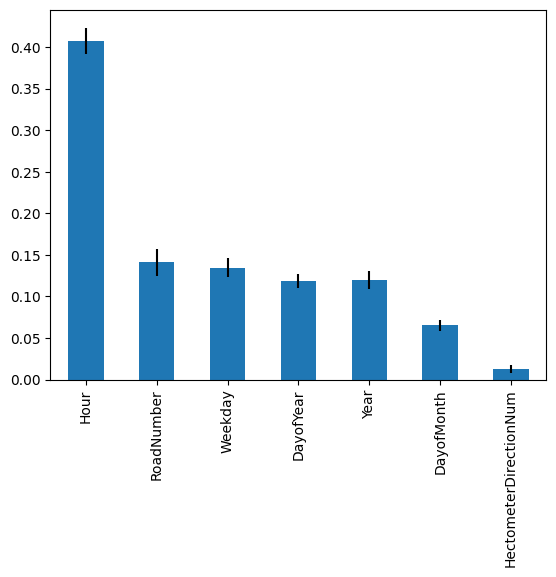

In [52]:
forest_importances = pd.Series(random_forest.feature_importances_, index=features)
standard_deviation = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
plt.figure()
forest_importances.plot.bar(yerr=standard_deviation)
plt.show()

#### Confusion matrix


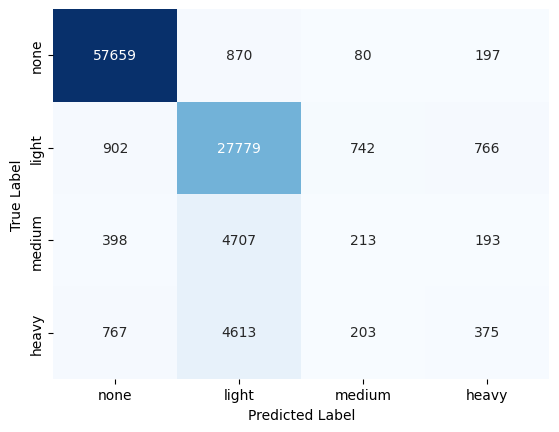

In [62]:
from sklearn.metrics import confusion_matrix

labels = category_mapping

matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=None, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Cross-validation

In [41]:
warnings.filterwarnings('ignore')
patch_sklearn()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(random_forest, X_train, y_train, cv=skf, scoring='accuracy')# average accuracy score
print("Accuracy scores for each fold:", accuracy_scores)
average_accuracy = accuracy_scores.mean()
print("Average accuracy score:", average_accuracy)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


KeyboardInterrupt: 

### Inference

In [ ]:
warnings.filterwarnings('ignore')
today = date.today()

hour = 7
road = 2
direction = 0
weekday = today.weekday()
dayofyear = today.timetuple().tm_yday
year = today.year
dayofmonth = today.day

X_inference = pd.DataFrame([{"Hour": hour, 
                             "RoadNumber": road,
                             "Weekday": weekday,
                             "DayofYear": dayofyear,
                             "Year": year,
                             "DayofMonth": dayofmonth,
                             "HectometerDirectionNum": direction}])

prediction = random_forest.predict_proba(X_inference)

result = pd.DataFrame()
result["Probability"] = prediction[0]

result

,Probability
0,0.095000
1,0.713417
2,0.141189
3,0.050394
